# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

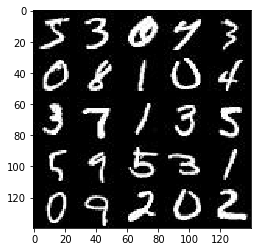

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

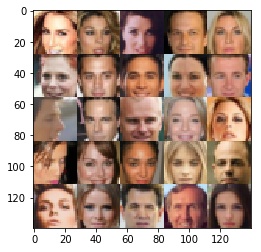

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                  name='real_input')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        
        #Layer 1
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * conv1, conv1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        #Layer 2
        conv2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(0.01 * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        #Layer 3
        conv3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(0.01 * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(relu3, rate=0.5)
        
        #Layer 4
        flat = tf.reshape(dropout3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """      
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        alpha = 0.1
        if is_train is True:
            drop = 0.5
        else:
            drop = 1.0
            
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        batch_norm1 = tf.layers.batch_normalization(g1, training=is_train)
        relu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        g2 = tf.layers.conv2d_transpose(dropout1, 256, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(g2, training=is_train)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        logits = tf.layers.conv2d_transpose(dropout2, out_channel_dim, 5, strides=2, padding='SAME')

        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*0.9))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*0.9))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1=0.5):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode,print_every=10, 
          show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #build network
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2],
                                           data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for x in get_batches(batch_size):
                steps += 1
                x = x*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

    return losses, samples     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5074... Generator Loss: 2.4526
Epoch 1/2... Discriminator Loss: 1.5322... Generator Loss: 0.6332
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 3.2843
Epoch 1/2... Discriminator Loss: 1.0068... Generator Loss: 1.2739
Epoch 1/2... Discriminator Loss: 1.5937... Generator Loss: 0.5034
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 0.7067
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 0.9337... Generator Loss: 1.3811
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 1.7548
Epoch 1/2... Discriminator Loss: 1.1132... Generator Loss: 0.7287


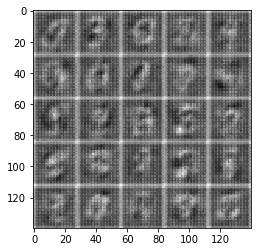

Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 0.7550
Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 1.7452
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 1.1964
Epoch 1/2... Discriminator Loss: 0.9401... Generator Loss: 1.4067
Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 0.5757
Epoch 1/2... Discriminator Loss: 0.9981... Generator Loss: 0.8497
Epoch 1/2... Discriminator Loss: 0.7858... Generator Loss: 1.1568
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.6662
Epoch 1/2... Discriminator Loss: 0.8638... Generator Loss: 1.0815
Epoch 1/2... Discriminator Loss: 0.9052... Generator Loss: 1.0714


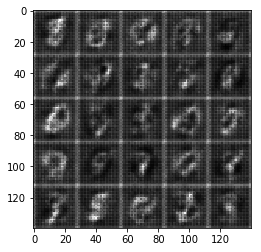

Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 1.9056
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 0.7940
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 0.9358
Epoch 1/2... Discriminator Loss: 0.8657... Generator Loss: 1.0202
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.8495
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 1.0393
Epoch 1/2... Discriminator Loss: 0.9026... Generator Loss: 1.7880
Epoch 1/2... Discriminator Loss: 0.7774... Generator Loss: 1.2354
Epoch 1/2... Discriminator Loss: 0.7215... Generator Loss: 1.5992
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 1.4217


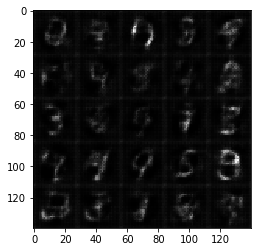

Epoch 1/2... Discriminator Loss: 0.6401... Generator Loss: 1.8255
Epoch 1/2... Discriminator Loss: 0.7421... Generator Loss: 1.2485
Epoch 1/2... Discriminator Loss: 0.7199... Generator Loss: 2.2636
Epoch 1/2... Discriminator Loss: 0.9036... Generator Loss: 1.1338
Epoch 1/2... Discriminator Loss: 0.9042... Generator Loss: 1.1340
Epoch 1/2... Discriminator Loss: 0.8202... Generator Loss: 1.2167
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 0.7385
Epoch 1/2... Discriminator Loss: 0.7891... Generator Loss: 1.6796
Epoch 1/2... Discriminator Loss: 0.7718... Generator Loss: 1.5401
Epoch 1/2... Discriminator Loss: 0.8167... Generator Loss: 1.8177


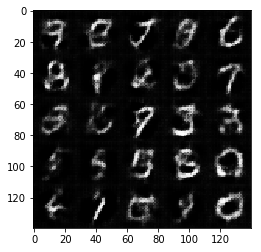

Epoch 1/2... Discriminator Loss: 0.9557... Generator Loss: 1.0040
Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 0.9085
Epoch 1/2... Discriminator Loss: 0.9638... Generator Loss: 0.8976
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 1.7258
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 0.7945... Generator Loss: 1.6414
Epoch 1/2... Discriminator Loss: 0.7631... Generator Loss: 1.7825
Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 1.8543
Epoch 1/2... Discriminator Loss: 0.7436... Generator Loss: 1.4237
Epoch 1/2... Discriminator Loss: 0.8762... Generator Loss: 1.1478


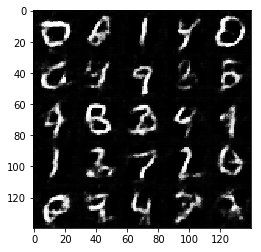

Epoch 1/2... Discriminator Loss: 0.7775... Generator Loss: 1.3300
Epoch 1/2... Discriminator Loss: 0.9003... Generator Loss: 1.0311
Epoch 1/2... Discriminator Loss: 0.8941... Generator Loss: 1.1557
Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 1.8152
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 0.8397
Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 1.2779
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 2.2942
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 0.9748
Epoch 1/2... Discriminator Loss: 1.0248... Generator Loss: 0.8362


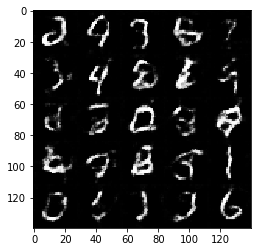

Epoch 1/2... Discriminator Loss: 0.7254... Generator Loss: 1.7700
Epoch 1/2... Discriminator Loss: 0.7952... Generator Loss: 1.2558
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.6446
Epoch 1/2... Discriminator Loss: 0.7593... Generator Loss: 1.4069
Epoch 1/2... Discriminator Loss: 0.9401... Generator Loss: 0.9247
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 0.9670... Generator Loss: 1.7429
Epoch 1/2... Discriminator Loss: 0.9898... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 0.9040
Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.6335


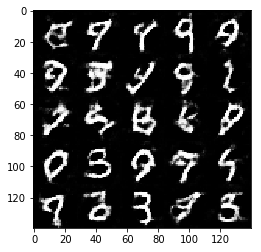

Epoch 1/2... Discriminator Loss: 0.7127... Generator Loss: 1.5243
Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 1.4936
Epoch 1/2... Discriminator Loss: 0.8103... Generator Loss: 1.2307
Epoch 1/2... Discriminator Loss: 1.0004... Generator Loss: 0.9465
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 0.8631
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 0.9056
Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 1.0220
Epoch 1/2... Discriminator Loss: 0.7928... Generator Loss: 1.4335
Epoch 1/2... Discriminator Loss: 0.7304... Generator Loss: 1.5870
Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 0.7136


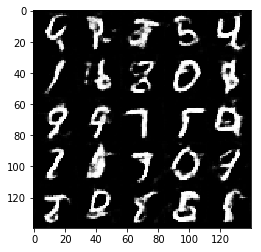

Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 0.8877
Epoch 1/2... Discriminator Loss: 0.7154... Generator Loss: 1.6482
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 1.8817
Epoch 1/2... Discriminator Loss: 0.6927... Generator Loss: 1.5002
Epoch 1/2... Discriminator Loss: 0.8405... Generator Loss: 1.3316
Epoch 1/2... Discriminator Loss: 1.2125... Generator Loss: 0.6876
Epoch 1/2... Discriminator Loss: 0.7843... Generator Loss: 1.2419
Epoch 1/2... Discriminator Loss: 1.0462... Generator Loss: 0.8550
Epoch 1/2... Discriminator Loss: 0.7104... Generator Loss: 1.5641
Epoch 1/2... Discriminator Loss: 0.7953... Generator Loss: 1.1337


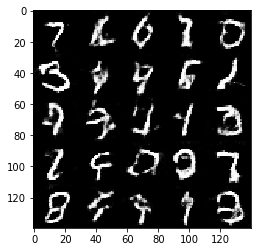

Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 1.3830
Epoch 1/2... Discriminator Loss: 2.6851... Generator Loss: 0.3745
Epoch 1/2... Discriminator Loss: 1.7649... Generator Loss: 0.5438
Epoch 2/2... Discriminator Loss: 0.9073... Generator Loss: 1.3221
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 1.0419
Epoch 2/2... Discriminator Loss: 0.8924... Generator Loss: 0.9641
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 0.8454
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.1821
Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 1.5037
Epoch 2/2... Discriminator Loss: 0.6463... Generator Loss: 1.5509


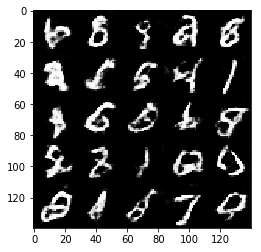

Epoch 2/2... Discriminator Loss: 1.0382... Generator Loss: 0.8480
Epoch 2/2... Discriminator Loss: 0.6739... Generator Loss: 1.4164
Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 1.2455
Epoch 2/2... Discriminator Loss: 0.7136... Generator Loss: 1.3618
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 0.9685
Epoch 2/2... Discriminator Loss: 0.9348... Generator Loss: 0.9415
Epoch 2/2... Discriminator Loss: 2.0055... Generator Loss: 0.4499
Epoch 2/2... Discriminator Loss: 0.9330... Generator Loss: 0.9484
Epoch 2/2... Discriminator Loss: 0.7099... Generator Loss: 1.3119
Epoch 2/2... Discriminator Loss: 0.7320... Generator Loss: 1.2935


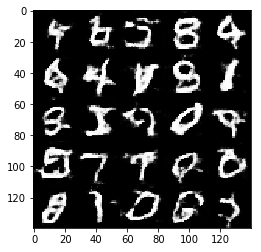

Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 0.9616
Epoch 2/2... Discriminator Loss: 0.8458... Generator Loss: 1.0490
Epoch 2/2... Discriminator Loss: 0.7512... Generator Loss: 1.2445
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 1.7843
Epoch 2/2... Discriminator Loss: 0.7699... Generator Loss: 1.2552
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 1.1185
Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 1.2105
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 1.2895
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 1.4896
Epoch 2/2... Discriminator Loss: 0.7285... Generator Loss: 1.3782


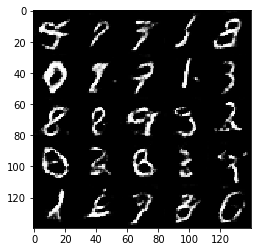

Epoch 2/2... Discriminator Loss: 0.6960... Generator Loss: 1.3797
Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 1.5437
Epoch 2/2... Discriminator Loss: 0.7476... Generator Loss: 1.2164
Epoch 2/2... Discriminator Loss: 0.6252... Generator Loss: 1.8009
Epoch 2/2... Discriminator Loss: 0.6477... Generator Loss: 1.6535
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 1.1140
Epoch 2/2... Discriminator Loss: 0.7321... Generator Loss: 1.9667
Epoch 2/2... Discriminator Loss: 0.6624... Generator Loss: 1.4127
Epoch 2/2... Discriminator Loss: 0.9687... Generator Loss: 1.1706
Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 1.4825


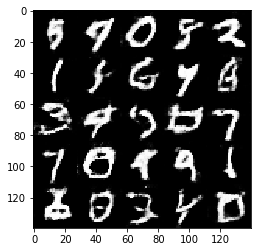

Epoch 2/2... Discriminator Loss: 0.9416... Generator Loss: 2.0280
Epoch 2/2... Discriminator Loss: 0.7826... Generator Loss: 1.1379
Epoch 2/2... Discriminator Loss: 0.6840... Generator Loss: 1.5595
Epoch 2/2... Discriminator Loss: 0.8209... Generator Loss: 1.1251
Epoch 2/2... Discriminator Loss: 0.6899... Generator Loss: 1.3305
Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 1.3795
Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 0.8099
Epoch 2/2... Discriminator Loss: 0.8577... Generator Loss: 2.6082
Epoch 2/2... Discriminator Loss: 0.6408... Generator Loss: 1.6460
Epoch 2/2... Discriminator Loss: 0.7350... Generator Loss: 1.5913


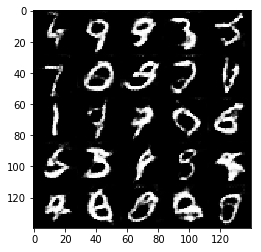

Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 1.2967
Epoch 2/2... Discriminator Loss: 0.6266... Generator Loss: 1.5561
Epoch 2/2... Discriminator Loss: 0.8157... Generator Loss: 1.1493
Epoch 2/2... Discriminator Loss: 5.3799... Generator Loss: 6.3469
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.7488
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 1.1380
Epoch 2/2... Discriminator Loss: 0.8635... Generator Loss: 1.0750
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 0.7764... Generator Loss: 1.2117
Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 1.7119


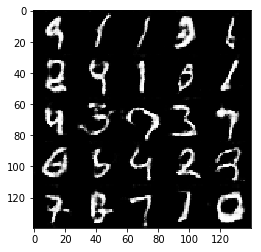

Epoch 2/2... Discriminator Loss: 0.8691... Generator Loss: 1.0021
Epoch 2/2... Discriminator Loss: 0.6648... Generator Loss: 1.5811
Epoch 2/2... Discriminator Loss: 0.6878... Generator Loss: 1.3470
Epoch 2/2... Discriminator Loss: 0.6138... Generator Loss: 1.8103
Epoch 2/2... Discriminator Loss: 0.7041... Generator Loss: 1.4510
Epoch 2/2... Discriminator Loss: 0.8430... Generator Loss: 1.2028
Epoch 2/2... Discriminator Loss: 0.6591... Generator Loss: 1.5870
Epoch 2/2... Discriminator Loss: 0.7244... Generator Loss: 1.2728
Epoch 2/2... Discriminator Loss: 1.8202... Generator Loss: 0.4379
Epoch 2/2... Discriminator Loss: 0.6662... Generator Loss: 1.8173


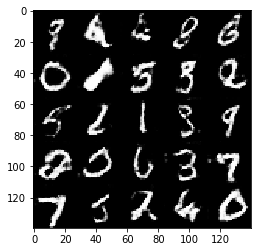

Epoch 2/2... Discriminator Loss: 0.6555... Generator Loss: 1.4477
Epoch 2/2... Discriminator Loss: 0.6683... Generator Loss: 2.0028
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.6503
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 0.9993
Epoch 2/2... Discriminator Loss: 0.6345... Generator Loss: 1.5241
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.2573
Epoch 2/2... Discriminator Loss: 0.6524... Generator Loss: 1.5214
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 0.8039
Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 1.4117
Epoch 2/2... Discriminator Loss: 0.6787... Generator Loss: 1.8778


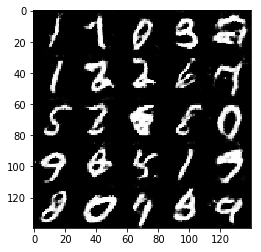

Epoch 2/2... Discriminator Loss: 0.9430... Generator Loss: 0.9801
Epoch 2/2... Discriminator Loss: 0.6821... Generator Loss: 1.3384
Epoch 2/2... Discriminator Loss: 0.9363... Generator Loss: 0.9264
Epoch 2/2... Discriminator Loss: 1.1684... Generator Loss: 0.8265
Epoch 2/2... Discriminator Loss: 0.6749... Generator Loss: 1.3639
Epoch 2/2... Discriminator Loss: 0.7425... Generator Loss: 1.2372
Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 1.5246
Epoch 2/2... Discriminator Loss: 0.7962... Generator Loss: 1.1414
Epoch 2/2... Discriminator Loss: 0.8939... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 0.9617... Generator Loss: 1.0571


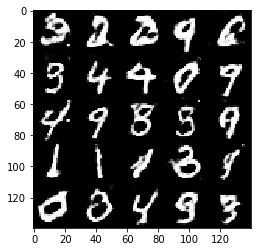

Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 1.0196
Epoch 2/2... Discriminator Loss: 0.5859... Generator Loss: 1.7310
Epoch 2/2... Discriminator Loss: 0.6559... Generator Loss: 1.3917
Epoch 2/2... Discriminator Loss: 0.6923... Generator Loss: 1.3830
Epoch 2/2... Discriminator Loss: 0.7205... Generator Loss: 1.8936
Epoch 2/2... Discriminator Loss: 0.6637... Generator Loss: 1.4404
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.7132


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 3.7137
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 2.1597
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 1.6996... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.3094
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.9181


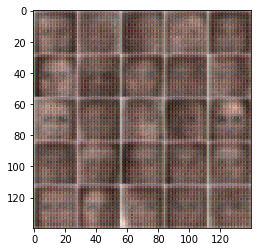

Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 1.4140
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 1.4936
Epoch 1/1... Discriminator Loss: 1.7442... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 1.8102
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.0570


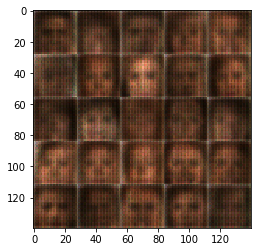

Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 1.3508
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.4166
Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 2.3342
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.7886
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.4468
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.7379


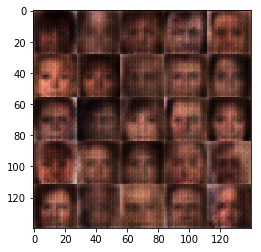

Epoch 1/1... Discriminator Loss: 0.6052... Generator Loss: 2.5398
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 3.2970
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6878


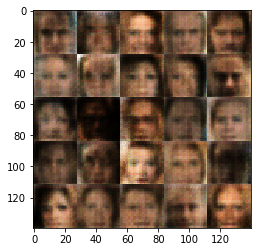

Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 3.7760
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 0.6787... Generator Loss: 1.5827
Epoch 1/1... Discriminator Loss: 0.6778... Generator Loss: 2.2261
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 2.6324
Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 3.4308


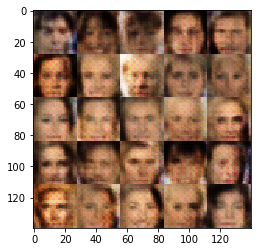

Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 1.8840
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 3.4901
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 5.5820
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 1.8200
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 2.0366
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 3.1081
Epoch 1/1... Discriminator Loss: 1.6206... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 0.7095... Generator Loss: 1.6815


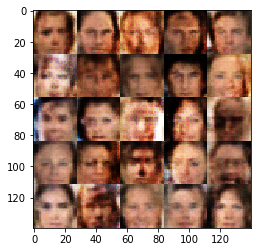

Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 1.6908
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 1.9881
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.4039
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 1.6775
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 0.4970... Generator Loss: 2.9010
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 1.0968


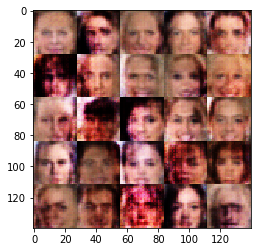

Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 2.6558
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 1.3546
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 2.3316
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 1.4719
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 4.0013


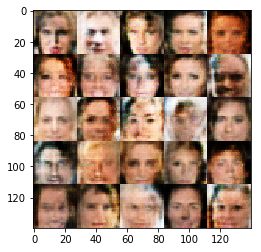

Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 5.1761
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.5994... Generator Loss: 5.2357
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 3.5901
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 1.8256
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 2.7310
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.2099
Epoch 1/1... Discriminator Loss: 0.4612... Generator Loss: 2.1400
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 1.7169
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.8288


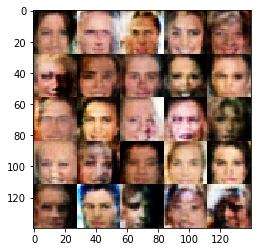

Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 3.4961
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 2.2432
Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 3.7805
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 6.0405
Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 3.4480
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 2.8782
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 3.7786
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 4.3367
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 6.1326
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 1.1213


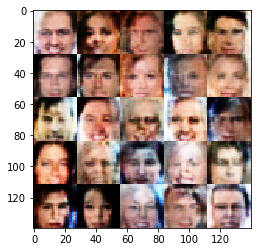

Epoch 1/1... Discriminator Loss: 0.5086... Generator Loss: 1.8612
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 4.4568
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.6321
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 2.1772
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 2.7073
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 6.6272
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 3.5763
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 2.2016


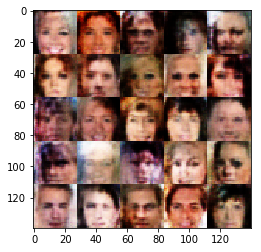

Epoch 1/1... Discriminator Loss: 0.6642... Generator Loss: 4.2557
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 4.1820
Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 3.1987
Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 2.0077
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 4.3528
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 3.0844
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 2.6890
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 1.3624


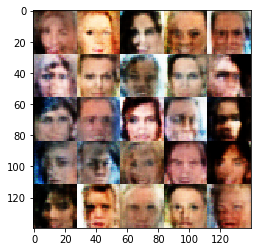

Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 5.8402
Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 2.4559
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 2.9666
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 2.6477
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 2.0961
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 6.9648
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 2.5028
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 6.1233


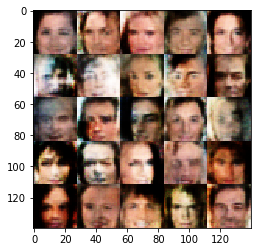

Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 4.7443
Epoch 1/1... Discriminator Loss: 0.3723... Generator Loss: 4.2321
Epoch 1/1... Discriminator Loss: 0.3498... Generator Loss: 4.5453
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 5.2114
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 1.9008
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 3.7999
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 2.6688
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 2.7098
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 1.9309


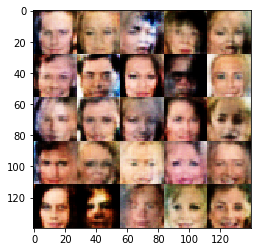

Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 5.5868
Epoch 1/1... Discriminator Loss: 0.3421... Generator Loss: 5.9942
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 5.2111
Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 2.0543
Epoch 1/1... Discriminator Loss: 0.4321... Generator Loss: 2.7073
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 6.1443
Epoch 1/1... Discriminator Loss: 0.5326... Generator Loss: 5.9335
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 3.4818
Epoch 1/1... Discriminator Loss: 0.3765... Generator Loss: 3.2027


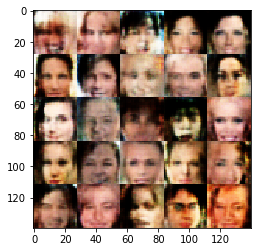

Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 3.1184
Epoch 1/1... Discriminator Loss: 0.4819... Generator Loss: 2.4293
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 2.9971
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 3.2509
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 2.5071
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 6.8093
Epoch 1/1... Discriminator Loss: 0.5414... Generator Loss: 1.9674


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.